In [21]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit
import pandas as pd
from tqdm import tqdm
np.random.seed(42)

import plotly.express as px

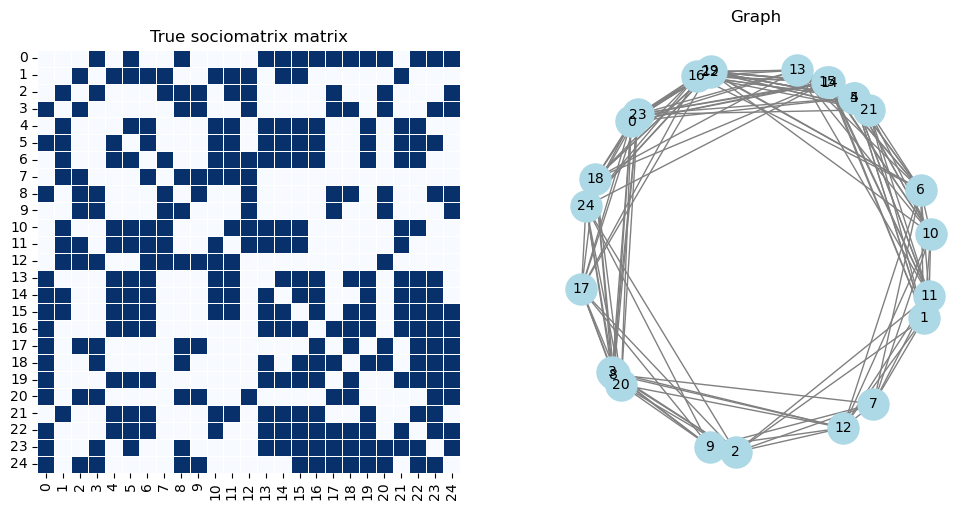

In [22]:
n = 25
a_real = 10.0
Z_real = np.array([[np.cos(theta), np.sin(theta)] for theta in 2*np.pi*np.random.rand(n)])

Y_real = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            d = -Z_real[i].T @ Z_real[j] + 1
            Y_real[i,j] = expit(a_real * (1 - d))
            if np.random.rand() < Y_real[i,j]:
                Y_real[i,j] = 1
                Y_real[j,i] = 1
            else:
                Y_real[i,j] = 0
                Y_real[j,i] = 0

G = nx.from_numpy_array(Y_real)

# Dibujar el grafo con posiciones en la circunferencia
pos = {i: Z_real[i] for i in range(n)}

plt.figure(figsize=(12,6))
plt.subplot(121)
sns.heatmap(Y_real, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("True sociomatrix matrix")

plt.subplot(122)
nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', edge_color='gray', font_size=10)
plt.title("Graph")
plt.show()

# Forward example

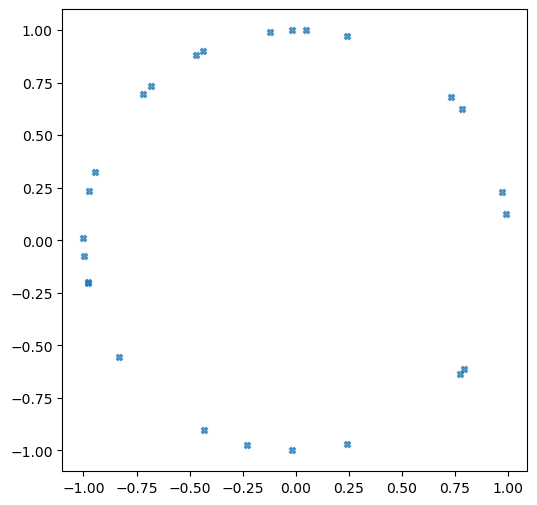

In [23]:
angles_init_r = 2*np.pi*np.random.rand(n)
Z_init_r = np.stack((np.cos(angles_init_r), np.sin(angles_init_r)), axis=1)

plt.figure(figsize=(6,6))
plt.scatter(Z_init_r[:, 0], Z_init_r[:, 1], s=20, alpha=0.7,marker="X")
plt.show()

-417.1389141031208
-416.08170639619897


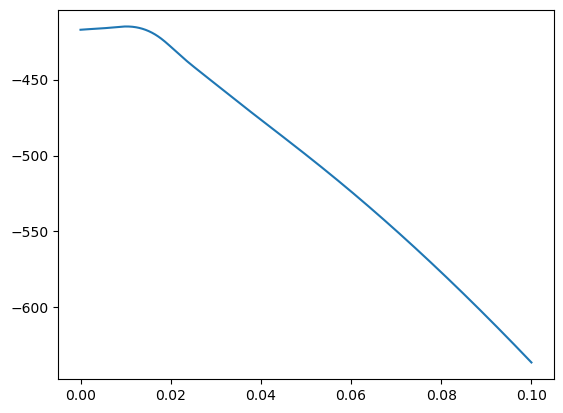

In [24]:
def loglikelihood(Z,a):
    total = 0.0
    for i in G.nodes():
        for j in G.nodes():
            d = - Z[i].T @ Z[j] + 1
            eta = a * (1 - d)
            if j in G.neighbors(i):
                total += eta * 1  + (-np.logaddexp(0, eta))
            elif j != i:
                total += (-np.logaddexp(0, eta))
    return total

def grad_loglikelihood(Z,a):
    grad_Z = np.zeros_like(Z)
    grad_a = 0.0
    for i in G.nodes():
        for j in G.nodes():
            if j != i:
                y = 1.0 if j in G.neighbors(i) else 0.0
                dist = - Z[i].T @ Z[j] + 1
                eta = a* ( 1 - dist )
                grad_Z[i,:] +=  (y-expit(eta)) *  (-Z[j])
                grad_a += (y-expit(eta)) * (1 - dist) 
    return grad_Z, grad_a

def update_Z(Z, grad_Z):
    for i in range(len(Z)):
        proj_orth = grad_Z[i]-np.dot(Z[i], grad_Z[i]) * Z[i]
        Z[i] = Z[i] + proj_orth 
        Z[i] = Z[i] / np.linalg.norm(Z[i])
    return Z

grad_Z,  grad_a = grad_loglikelihood(Z_init_r,0.1)
lr = 0.005
print(loglikelihood(Z_init_r,0.1))
print(loglikelihood(update_Z(Z_init_r, lr*grad_Z),0.1+lr*grad_a))
plt.plot(np.linspace(0.0,0.1,1000),[loglikelihood(update_Z(Z_init_r, lr*grad_Z),0.1+lr*grad_a) for lr in np.linspace(0.0,0.1,1000)])
plt.show()

### Searching MLE

In [25]:
def SearchingMLE(Z_init, a_init, tol=1e-2, max_iter=1000, alpha_init=0.1, rho=0.5, c=1e-4):
    Z0 = Z_init
    historyZ = [Z0]

    a0 = a_init
    historya = [a0]
    
    for i in range(max_iter):
        grad_Z,  grad_a = grad_loglikelihood(Z0,a0)
        if np.linalg.norm(grad_Z) + np.abs(grad_a) < tol:
            break  # Convergence criterion
        
        alpha = alpha_init
        
        # Line search using the Armijo condition
        while loglikelihood(update_Z(Z0, alpha*grad_Z) ,a0 + alpha*grad_a) < loglikelihood(Z0,a0)+ c * alpha * (np.trace(np.transpose(grad_Z) @ Z0) + grad_a * a0):
            alpha *= rho
            if alpha < 1e-4:
                alpha = 0.0
                break
        
        # Update step
        Z0 = update_Z(Z0, alpha*grad_Z) 
        a0 = a0 + alpha * grad_a
        
        historyZ.append(Z0)
        historya.append(a0)
    
    return  Z0, a0, historyZ, historya

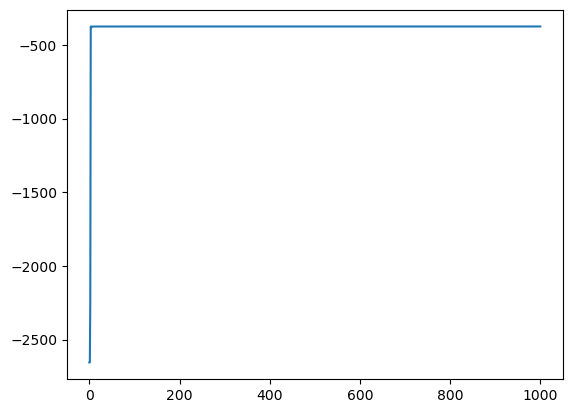

In [26]:
Z_ML, a_ML, historyZ, historya  =  SearchingMLE(Z_real , a_real)
plt.plot([loglikelihood(historyZ[t],historya[t]) for t in range(len(historya))])
plt.show()

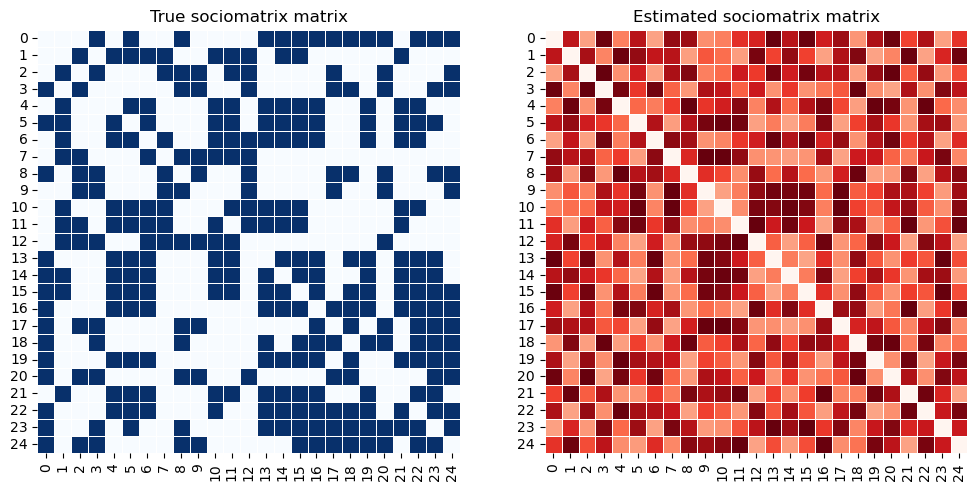

In [27]:
Y_MLE = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            d = -Z_ML[i].T @ Z_ML[j] +1
            Y_MLE[i,j] = expit(a_ML * (1 - d))

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.heatmap(nx.to_numpy_array(G, dtype=int), annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("True sociomatrix matrix")
plt.subplot(1,2,2)
sns.heatmap(Y_MLE, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("Estimated sociomatrix matrix")
plt.show()

## Prior distribution

85.98276541359854
89.467517011306


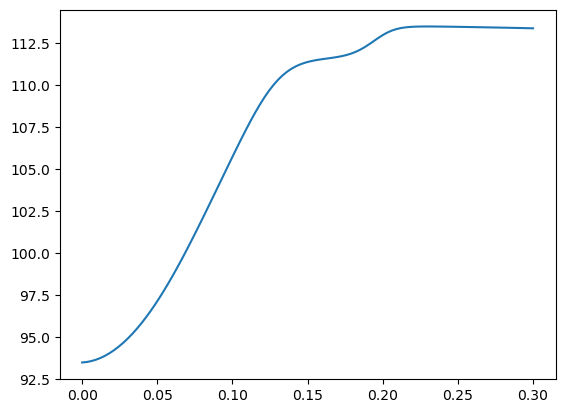

In [28]:
def logpriori(Z,a,var=0.1):
    logpriorZ = 0.0
    for i in range(len(Z)):
        logpriorZ += np.log(0.1 - (Z[i].T @ Z[i] -1)**2)
        logpriorZ +=  (Z_ML[i].T @ Z[i] - 1)
    logpriora = 0.5 * a**2 / var
    return (-1) * (np.log((2*np.pi*var)**((n+1)/2)) + logpriorZ + logpriora)


def grad_logpriori(Z,a,var=0.1):
    grad_Z = np.zeros_like(Z)
    for i in G.nodes():
        grad_Z[i,:] = 4 * Z[i] * (Z[i].T @ Z[i] -1) / (0.1 - (Z[i].T @ Z[i] -1)**2)
        grad_Z[i,:] += -Z_ML[i] 
    grad_a = (-1) * a / var  
    return grad_Z, grad_a

grad_Z,  grad_a = grad_logpriori(Z_init_r,0.1)
lr = 1.0
print(logpriori(Z_init_r,0.1))
print(logpriori(update_Z(Z_init_r, lr*grad_Z),0.1+lr*grad_a))
plt.plot(np.linspace(0.0,0.3,100),[logpriori(update_Z(Z_init_r, lr*grad_Z),0.1+lr*grad_a) for lr in np.linspace(0.0,0.3,100)])
plt.show()

## Potential energy

340.1286175944763
540.6375182759606


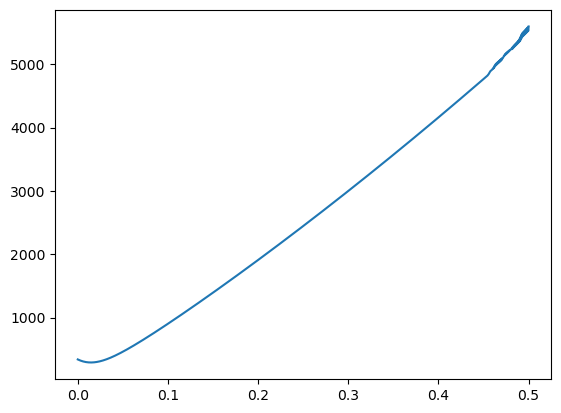

In [29]:
def U(Z,a,var=1):
    return (-1) * (loglikelihood(Z,a) + logpriori(Z,a,var))

def grad_U(Z,a,var=1):
    grad_Z_likelihood, grad_a_likelihood = grad_loglikelihood(Z,a)
    grad_Z_priori, grad_a_priori = grad_logpriori(Z,a,var)
    grad_Z = grad_Z_likelihood + grad_Z_priori
    grad_a = grad_a_likelihood + grad_a_priori
    return -grad_Z, -grad_a

grad_Z,  grad_a = grad_U(Z_init_r,0.1)
lr = 0.06
print(U(Z_init_r,0.1))
print(U(update_Z(Z_init_r, -lr*grad_Z),0.1 - lr*grad_a))
plt.plot(np.linspace(0.0,0.5,1000),[U(update_Z(Z_init_r, -lr*grad_Z),0.1-lr*grad_a) for lr in np.linspace(0.0,0.5,1000)])
plt.show()

## Applying Hamiltonian Monte Carlo Algorithm

In [30]:
def project_to_tangent_space(theta, phi):
    return phi - np.dot(phi, theta) * theta
def geodesic_flow(theta, phi, step_size):
    alpha = np.linalg.norm(phi)
    if alpha > 1e-10:
        new_theta = theta * np.cos(alpha * step_size) + (phi / alpha) * np.sin(alpha * step_size)
        new_phi = phi * np.cos(alpha * step_size) - alpha * theta * np.sin(alpha * step_size)
    else:
        new_theta, new_phi = theta, phi  # Evita división por cero
    return new_theta, new_phi
def compute_star(Old, Ref):
    ang_old = np.arctan2(Old[:,1], Old[:,0])
    ang_ref = np.arctan2(Ref[:,1], Ref[:,0])
    
    addition = np.mean(ang_ref-ang_old)
    
    ang_new = ang_old + addition

    #print("Addition: ", addition)
    New = np.zeros_like(Old)
    New[:,0] = np.cos(ang_new)
    New[:,1] = np.sin(ang_new)
    return New 

In [31]:
angles = 2*np.pi*np.random.rand(n)
Z1 = np.stack((np.cos(angles), np.sin(angles)), axis=1)
a1 = np.float64(0.0 + np.random.randn())

print("Log-L MLE:", loglikelihood(Z_ML,a_ML))
print("Log-L starter:", loglikelihood(Z1,a1))

Log-L MLE: -374.90835804698435
Log-L starter: -406.1443909456045


In [32]:
def ghmc(Z_init, a_init, num_samples, epsilon_init=0.05, std_dev_init=1.0, warmup=100):
    samples_Z = [Z_init]
    samples_a = [a_init]
    Hamiltonian_p = [U(Z_init,a_init)]

    # Parámetros adaptativos
    epsilon = epsilon_init
    std_dev = std_dev_init
    L = max(1, int(round(1/epsilon)))  # L = 1/ε
    accept_count = 0
    total_updates = 0

    acep_rate_history = np.zeros(num_samples)
    
    for iter in tqdm(range(num_samples)):

        Z = samples_Z[-1].copy()
        a = samples_a[-1].copy()


        # Adaptación de parámetros
        adapting = iter < warmup
        if adapting and iter > 0 and iter % 2 == 0:
            # Ajustar epsilon basado en tasa de aceptación reciente
            current_accept_rate = accept_count / total_updates if total_updates > 0 else 0
            if current_accept_rate < 0.80:
                epsilon = np.max(np.array([0.01,0.99*epsilon])) 
                std_dev = np.max(np.array([0.25,0.99*std_dev]))
            elif current_accept_rate > 0.60:
                epsilon = np.min(np.array([0.2,1.01*epsilon]))
                std_dev = np.min(np.array([0.75,1.01*std_dev]))
            L = max(1, int(round(1/epsilon)))  # Actualizar L
        elif iter == warmup:
            print(f"Final parameters: epsilon={epsilon:.4f}, L={L}, std_dev={std_dev:.4f}")



        


        ### HMC algorithm for Z

        for i in range(Z.shape[0]):
            Z_i = Z[i].copy()
            p_i = np.random.normal(0, std_dev, size=Z_i.shape)
            p_i = project_to_tangent_space(Z_i, p_i)
            current_p = p_i.copy()

            #Leapfrog integration
            grad_Z,  grad_a = grad_U(Z,samples_a[-1])
            grad_Z_i = grad_Z[i].copy()
            Z_i = Z[i].copy()
            p_i -= epsilon * grad_Z_i / 2 
            p_i = project_to_tangent_space(Z_i, p_i)       
            for _ in range(L):
                Z_i, p_i = geodesic_flow(Z_i, p_i, epsilon)
            Z[i] = Z_i.copy()
            grad_Z,  grad_a = grad_U(Z,samples_a[-1])
            grad_Z_i = grad_Z[i].copy()
            p_i -= epsilon * grad_Z_i / 2
            p_i = project_to_tangent_space(Z_i, p_i)

            

            # Hamiltonian
            current_U = U(samples_Z[-1],samples_a[-1])
            current_K = 0.5 * np.sum(current_p**2)
            current_H = current_U + current_K
            proposed_U = U(Z,samples_a[-1])
            proposed_K = 0.5 * np.sum(p_i**2)
            proposed_H = proposed_U + proposed_K
            # Metropolis-Hastings acceptance rate
            log_accept_ratio = current_H - proposed_H
            if log_accept_ratio > 0:
                #Z_C = compute_star(Z,Z_ML)
                samples_a.append(samples_a[-1])
                samples_Z.append(Z.copy())
                accept_count += 1
                Hamiltonian_p.append(proposed_H)
            elif np.random.rand() < np.exp(log_accept_ratio):
                #Z_C = compute_star(Z,Z_ML)
                samples_a.append(samples_a[-1])
                samples_Z.append(Z.copy())
                accept_count += 1
                Hamiltonian_p.append(proposed_H)
            else:
                samples_a.append(samples_a[-1])
                samples_Z.append(samples_Z[-1])
                Hamiltonian_p.append(current_H)
            total_updates += 1   

            grad_Z,  grad_a = grad_U(samples_Z[-1],samples_a[-1])

        

        ### HMC algorithm for a
        p = np.random.normal(0, std_dev, size=1)
        current_p = p.copy()
        #Leapfrog integration
        p -= epsilon * grad_a / 2        
        for _ in range(L):
            a += epsilon * p
            grad_Z,  grad_a = grad_U(samples_Z[-1],a)
            p -= epsilon * grad_a
        p -= epsilon * grad_a / 2
        p = -p  # Negate momentum to make the proposal symmetric
        # Hamiltonian
        current_U = U(samples_Z[-1],samples_a[-1])
        current_K = 0.5 * np.sum(current_p**2)
        current_H = current_U + current_K

        proposed_U = U(samples_Z[-1],a)
        proposed_K = 0.5 * np.sum(p**2)
        proposed_H = proposed_U + proposed_K
        
        # Metropolis-Hastings acceptance rate
        log_accept_ratio = current_H - proposed_H
        if log_accept_ratio > 0:
            samples_a.append(a.copy())
            samples_Z.append(samples_Z[-1])
            accept_count += 1
            Hamiltonian_p.append(proposed_H)
        elif np.random.rand() < np.exp(log_accept_ratio):
            samples_a.append(a.copy())
            samples_Z.append(samples_Z[-1])
            accept_count += 1
            Hamiltonian_p.append(proposed_H)
        else:
            samples_a.append(samples_a[-1])
            samples_Z.append(samples_Z[-1])
            Hamiltonian_p.append(current_H)
        total_updates += 1    
        acep_rate_history[iter] = accept_count / total_updates if total_updates > 0 else 0
    aceptance_rate = accept_count / total_updates
    print(f"Acceptance rate: {aceptance_rate:.5f}")
    
    samples_Z = np.array(samples_Z)
    samples_a = [np.float64(s.item()) if isinstance(s, np.ndarray) else np.float64(s) for s in samples_a]
    Hamiltonian_p = [np.float64(s.item()) if isinstance(s, np.ndarray) else np.float64(s) for s in Hamiltonian_p]
    return samples_Z, samples_a, Hamiltonian_p, acep_rate_history

In [33]:
def plot_Z_samples_on_circle(samples_Z, num_groups=15):
    samples_Z = np.array(samples_Z)
    num_points = samples_Z.shape[1]  # Número de grupos
    palette = sns.color_palette("tab10", num_groups)

    # Convertir coordenadas cartesianas a coordenadas polares
    angles = []
    for i in range(num_points):
        trace = samples_Z[:, i, :]
        x = trace[:, 0]
        y = trace[:, 1]
        theta = np.arctan2(y, x)  # Ángulo de cada punto en el plano
        angles.append(theta)
    
    # Crear el gráfico polar
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})
    
    # Dibujar el histograma para cada grupo en el círculo
    for i in range(num_points):
        theta = angles[i]
        # Crear el histograma en coordenadas polares
        ax.hist(theta, bins=30, color=palette[i], alpha=0.6, label=f'{i}')

    # Agregar títulos y etiquetas
    ax.set_title("Samples on Circle (Histogram Distribution)", fontsize=16)
    ax.set_xlabel("Theta (Angle)", fontsize=12)
    ax.set_ylabel("Density", fontsize=12)
    ax.grid(True)

    # Mostrar leyenda
    ax.legend(loc="best", fontsize="small")
    
    plt.tight_layout()
    plt.show()


In [34]:
# Execute HMC
samples_Z, samples_a, Hp, acep_rate_history = ghmc(Z1, a1, 200, epsilon_init=0.1, std_dev_init=0.5, warmup=1)
samples_Z = [compute_star(samples_Z[i],Z_real) for i in range(len(samples_Z))]
samples_Z = np.array(samples_Z)
# Estimators
## CM
Z_CM =  np.mean(samples_Z, axis=0)          
a_CM = np.mean(samples_a, axis=0)
## MAP
Z_MAP = samples_Z[np.argmin(Hp),:,:]
a_MAP = samples_a[np.argmin(Hp)]

  0%|          | 1/200 [00:01<03:23,  1.02s/it]

Final parameters: epsilon=0.1000, L=10, std_dev=0.5000


100%|██████████| 200/200 [05:58<00:00,  1.79s/it]

Acceptance rate: 0.36327


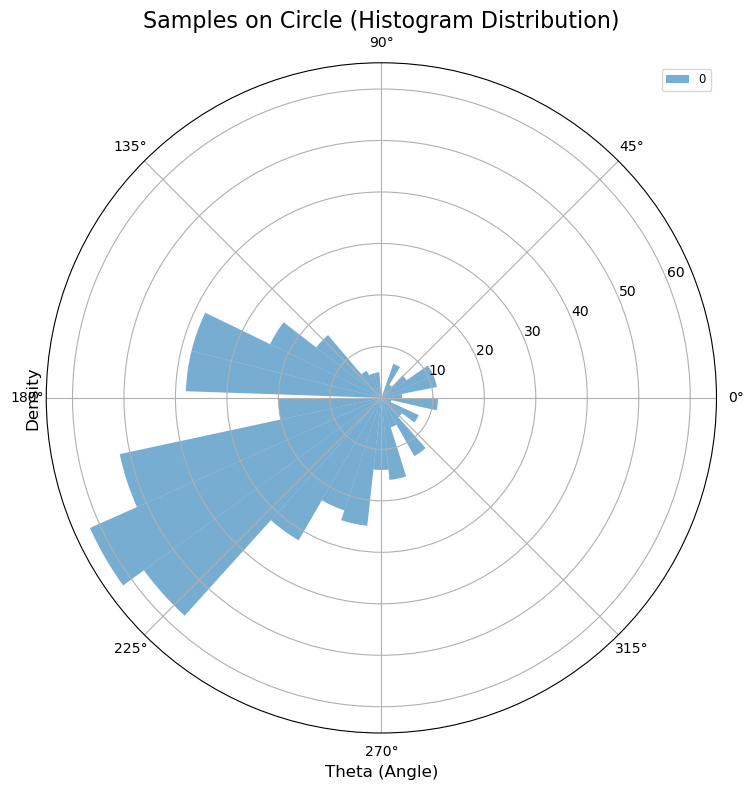

In [35]:
plot_Z_samples_on_circle(samples_Z[1:-1:10,0:1,:],1)

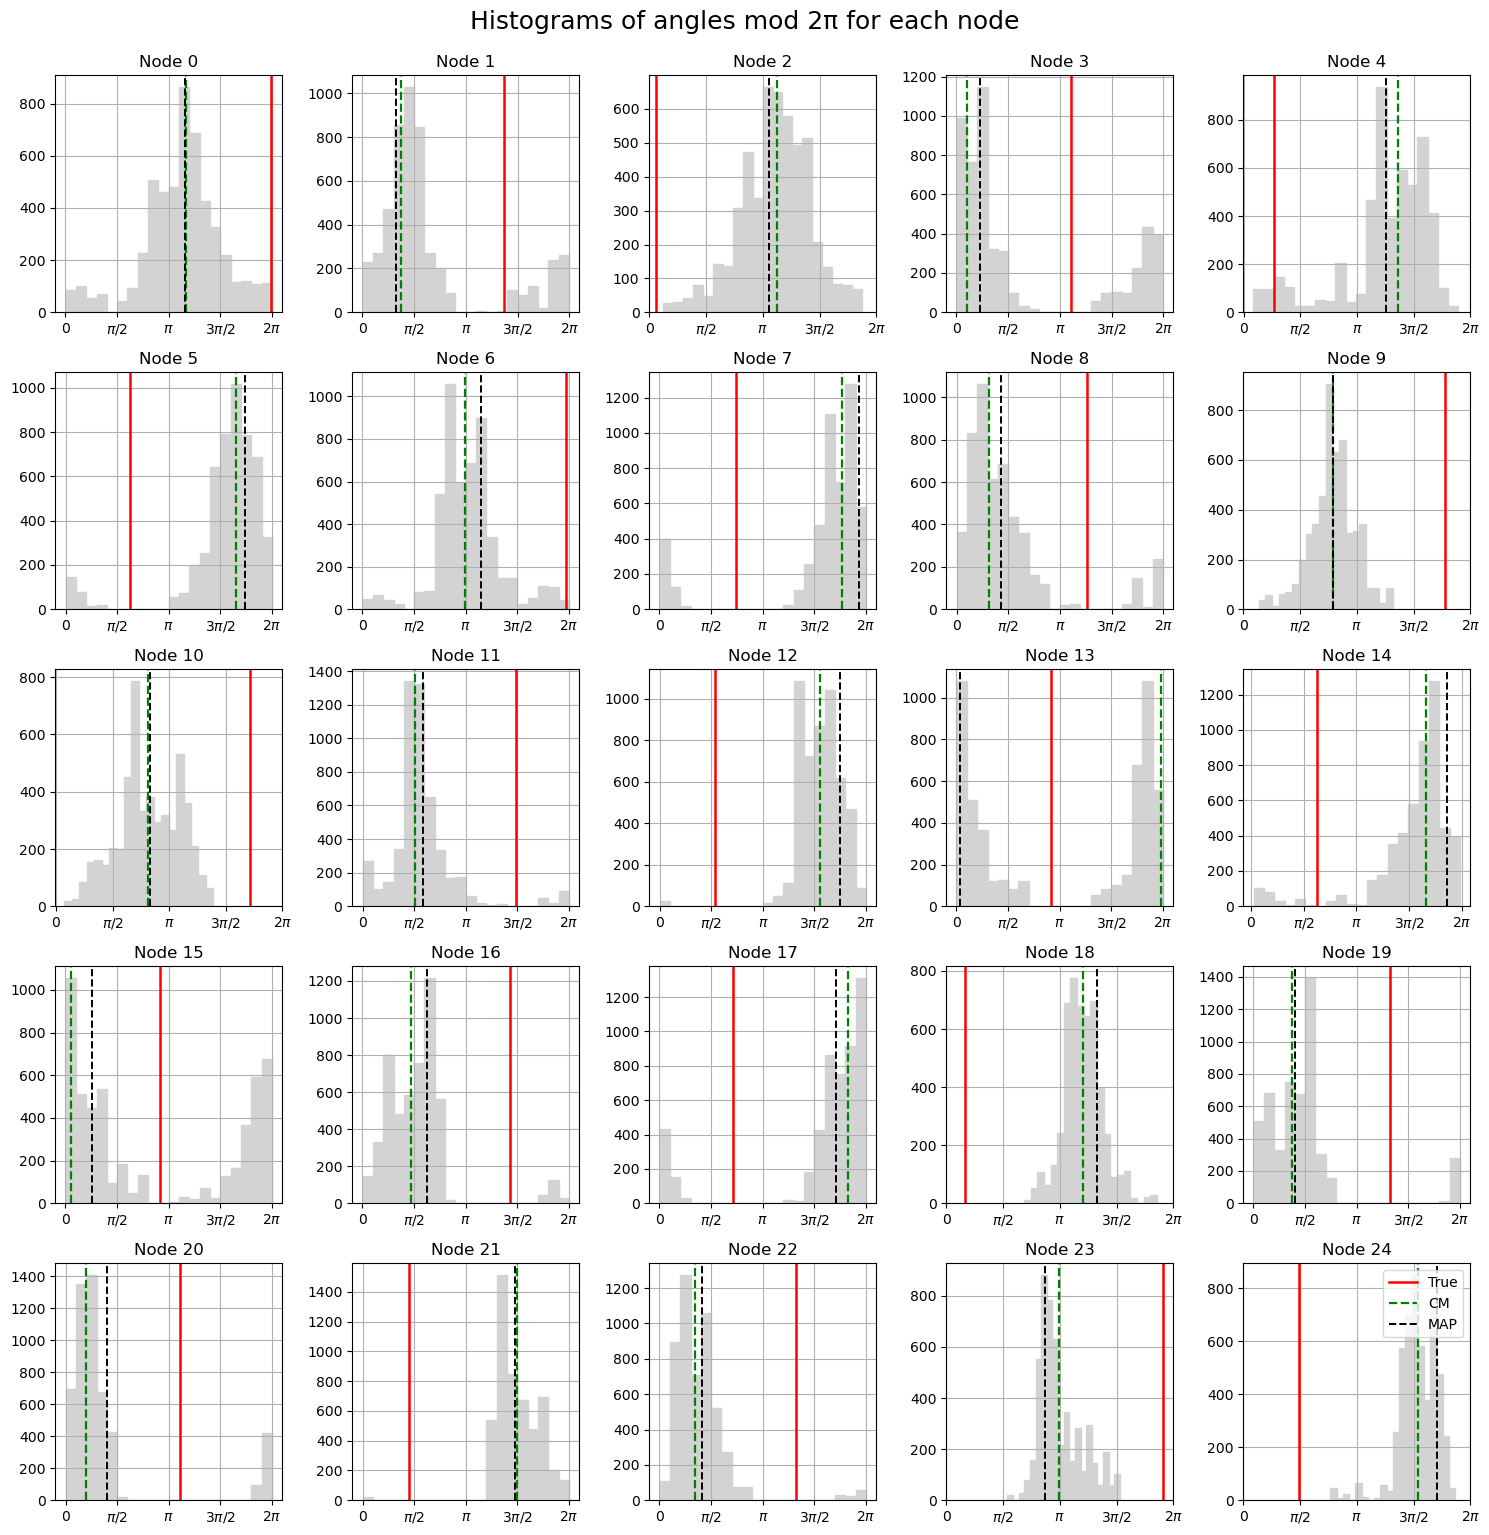

In [37]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))  
axes = axes.flatten() 

for i in range(n):
    ax = axes[i]
    # Ángulo polar mod 2π
    angles = np.mod(np.arctan2(samples_Z[100:, i, 1], samples_Z[100:, i, 0]), 2*np.pi)
    ax.hist(angles, bins=20, color='lightgray', edgecolor='lightgray')
    ax.axvline(np.mod(np.arctan2(Z_real[i, 1], Z_real[i, 0]), 2*np.pi), color='red', linewidth=1.8)
    ax.axvline(np.mod(np.arctan2(Z_CM[i, 1], Z_CM[i, 0]), 2*np.pi), color='green', linestyle='dashed', linewidth=1.6)
    ax.axvline(np.mod(np.arctan2(Z_MAP[i, 1], Z_MAP[i, 0]), 2*np.pi), color='black', linestyle='dashed', linewidth=1.4)
    ax.set_title(f'Node {i}')
    ax.set_xticks([0, np.pi/2, np.pi , 3*np.pi/2, 2*np.pi])
    ax.set_xticklabels(['0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$',r'$2\pi$'])
    ax.grid(True)
plt.tight_layout()
plt.legend(['True', 'CM','MAP'], loc='upper right')
plt.suptitle("Histograms of angles mod 2π for each node", y=1.02, fontsize=18) 
plt.show()

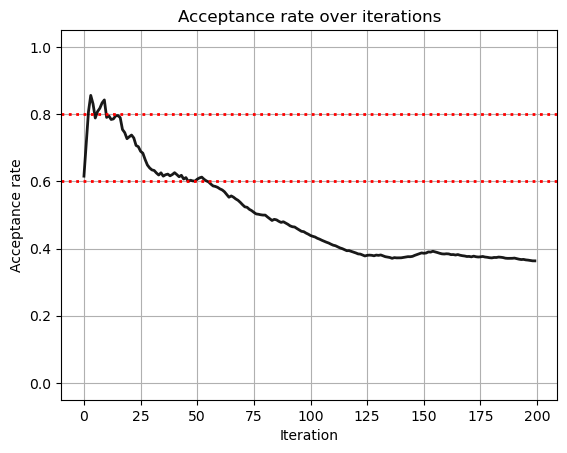

In [38]:
plt.plot(acep_rate_history, color='black', alpha=0.9, linewidth=2)
plt.axhline(0.80, color='red', linestyle=':', linewidth=2, label='')
plt.axhline(0.60, color='red', linestyle=':', linewidth=2)
plt.xlabel("Iteration")
plt.ylabel("Acceptance rate")
plt.title("Acceptance rate over iterations")
plt.ylim(-0.05, 1.05)
plt.grid(True)
plt.show()

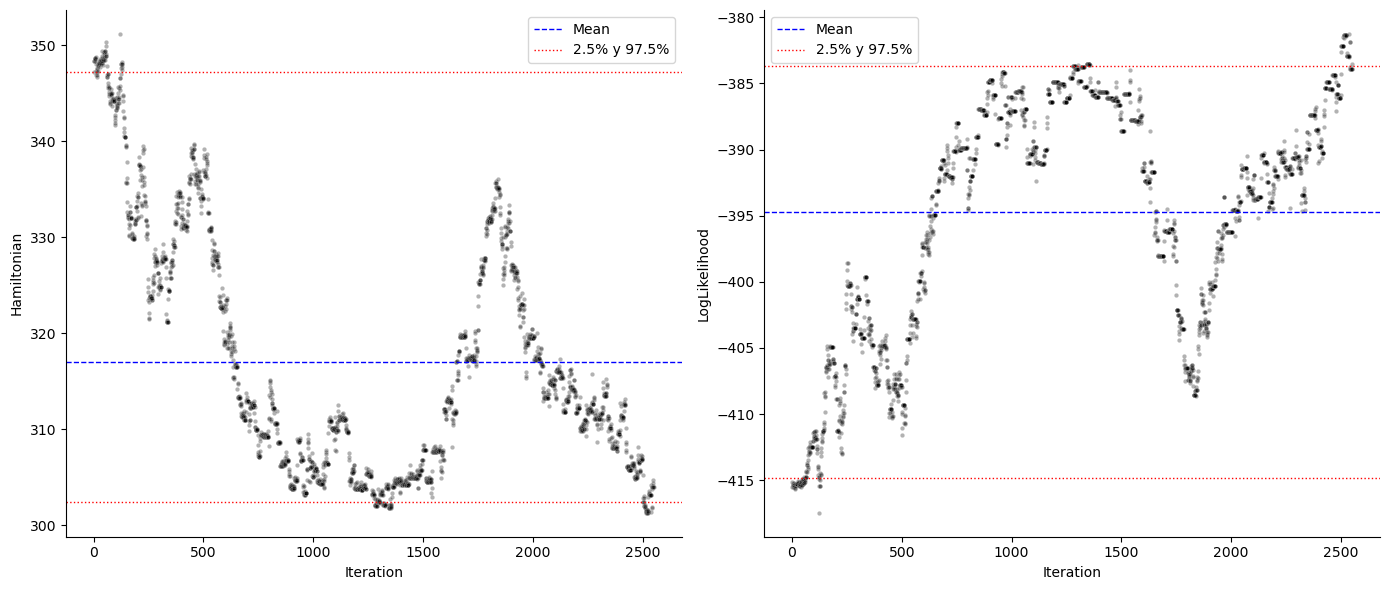

In [39]:
# 
x1 = Hp[100:-1:2]
iterations1 = np.arange(1, len(x1) + 1)
data1 = pd.DataFrame({
    'Iteration': iterations1,
    'LogLikelihood': x1
})
mean1 = np.mean(x1)
quantiles1 = np.quantile(x1, [0.025, 0.975])

# 
x2 = [np.float64(loglikelihood(samples_Z[i],samples_a[i]))for i in range(100,len(samples_a),2)]
iterations2 = np.arange(1, len(x2) + 1)
data2 = pd.DataFrame({
    'Iteration': iterations2,
    'LogLikelihood': x2
})
mean2 = np.mean(x2)
quantiles2 = np.quantile(x2, [0.025, 0.975])

#
fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # 1 fila, 2 columnas

# 
sns.scatterplot(ax=axs[0], x='Iteration', y='LogLikelihood', data=data1, color='black', alpha=0.3, s=10)
axs[0].axhline(mean1, color='blue', linestyle='--', linewidth=1, label='Mean')
axs[0].axhline(quantiles1[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axs[0].axhline(quantiles1[1], color='red', linestyle=':', linewidth=1)
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Hamiltonian")
axs[0].legend()


#
sns.scatterplot(ax=axs[1], x='Iteration', y='LogLikelihood', data=data2, color='black', alpha=0.3, s=10)
axs[1].axhline(mean2, color='blue', linestyle='--', linewidth=1, label='Mean')
axs[1].axhline(quantiles2[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axs[1].axhline(quantiles2[1], color='red', linestyle=':', linewidth=1)
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("LogLikelihood")
axs[1].legend()

sns.despine()
plt.tight_layout()
plt.show()


c:\Users\carlo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


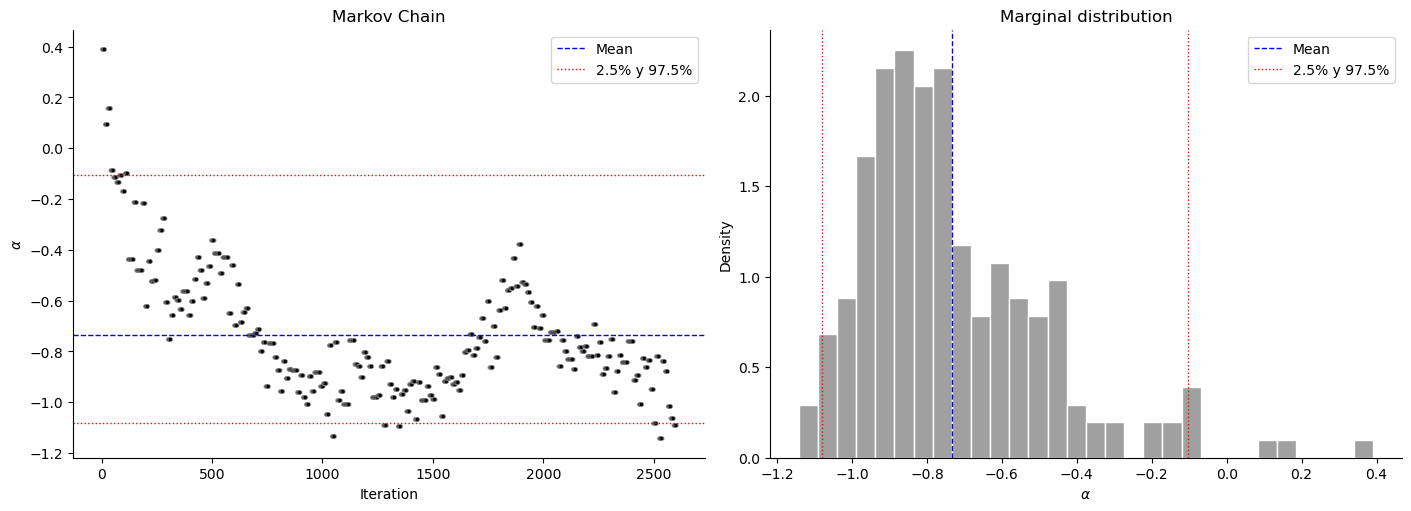

In [40]:
#
x = samples_a[1:-1:2]
#
iterations = np.arange(1, len(x) + 1)

mean_x = np.mean(x)
quantiles_x = np.quantile(x, [0.025, 0.975])

fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

sns.scatterplot(x=iterations, y=x, color='black', alpha=0.3, s=10, ax=axes[0])
axes[0].axhline(mean_x, color='blue', linestyle='--', linewidth=1, label='Mean')
axes[0].axhline(quantiles_x[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axes[0].axhline(quantiles_x[1], color='red', linestyle=':', linewidth=1)
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel(r"$\alpha$")
axes[0].set_title("Markov Chain")
axes[0].legend()
sns.despine(ax=axes[0])

sns.histplot(x, bins=30, kde=False, stat='density', color='gray', edgecolor='white', ax=axes[1])
axes[1].axvline(mean_x, color='blue', linestyle='--', linewidth=1, label='Mean')
axes[1].axvline(quantiles_x[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axes[1].axvline(quantiles_x[1], color='red', linestyle=':', linewidth=1)
axes[1].set_xlabel(r"$\alpha$")
axes[1].set_ylabel("Density")
axes[1].set_title("Marginal distribution")
axes[1].legend()
sns.despine(ax=axes[1])

plt.show()

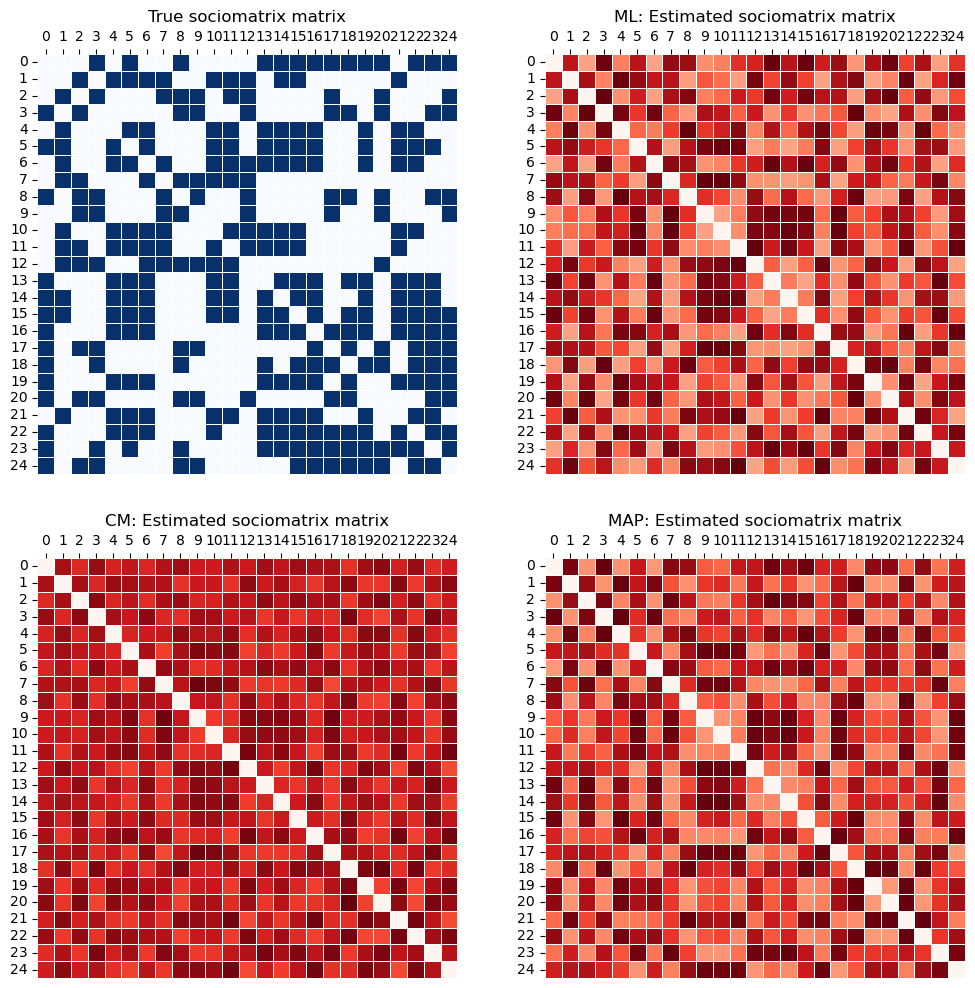

In [41]:
Y_CM_pp = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            d =  - Z_CM[i].T @ Z_CM[j] + 1
            Y_CM_pp[i,j] = expit(a_CM * (1 - d))


Y_MAP_pp = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            d = - Z_MAP[i].T @ Z_MAP[j] + 1
            Y_MAP_pp[i,j] = expit(a_MAP * (1 - d))




plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
ax1 = sns.heatmap(nx.to_numpy_array(G, dtype=int), annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
ax1.xaxis.set_ticks_position('top')
ax1.xaxis.set_label_position('top')


plt.title("True sociomatrix matrix")
plt.subplot(2,2,2)
ax2 = sns.heatmap(Y_MLE, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
ax2.xaxis.set_ticks_position('top')
ax2.xaxis.set_label_position('top')

plt.title("ML: Estimated sociomatrix matrix")
plt.subplot(2,2,3)
ax3 = sns.heatmap(Y_CM_pp, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
ax3.xaxis.set_ticks_position('top')
ax3.xaxis.set_label_position('top')

plt.title("CM: Estimated sociomatrix matrix")
plt.subplot(2,2,4)
ax4 = sns.heatmap(Y_MAP_pp, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
ax4.xaxis.set_ticks_position('top')
ax4.xaxis.set_label_position('top')

plt.title("MAP: Estimated sociomatrix matrix")
plt.show()